In [13]:
import pandas as pd

df = pd.read_csv(r'C:\Users\srust\Downloads\data.csv')
print(df.columns.tolist())

['No', 'year', 'month', 'day', 'hour', 'pm2.5', 'DEWP', 'TEMP', 'PRES', 'cbwd', 'Iws', 'Is', 'Ir']


Dataset size after downsampling: 14608
Train shape: (11676, 12, 11)
Test shape: (2920, 12, 11)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_4 (LSTM)                        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_5 (LSTM)                        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/80
183/183 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - loss: 0.1091 - val_loss: 0.0756
Epoch 2/80
183/183 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0559 - val_loss: 0.0408
Epoch 3/80
183/183 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.0317 - val_loss: 0.0245
Epoch 4/80
183/183 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 0.0202 - val_loss: 0.0166
Epoch 5/80
183/183 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.0145 - val_loss: 0.0125
Epoch 6/80
183/183 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0113 - val_loss: 0.0100
Epoch 7/80
183/183 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 0.0094 - val_loss: 0.0091
Epoch 8/80
183/183 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0083 - val_loss: 0.0078
Epoch 9/80
183/183 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0077 - val_loss: 0.0072
Epoch 10/80
183/183 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0071 - val_loss: 0.0067
Epoch 11/80
183/183 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.0067 - val_loss: 0.0063
Epoch 12/80
183/183 ━━━━━━━━━━━━━━━━━━━━ 

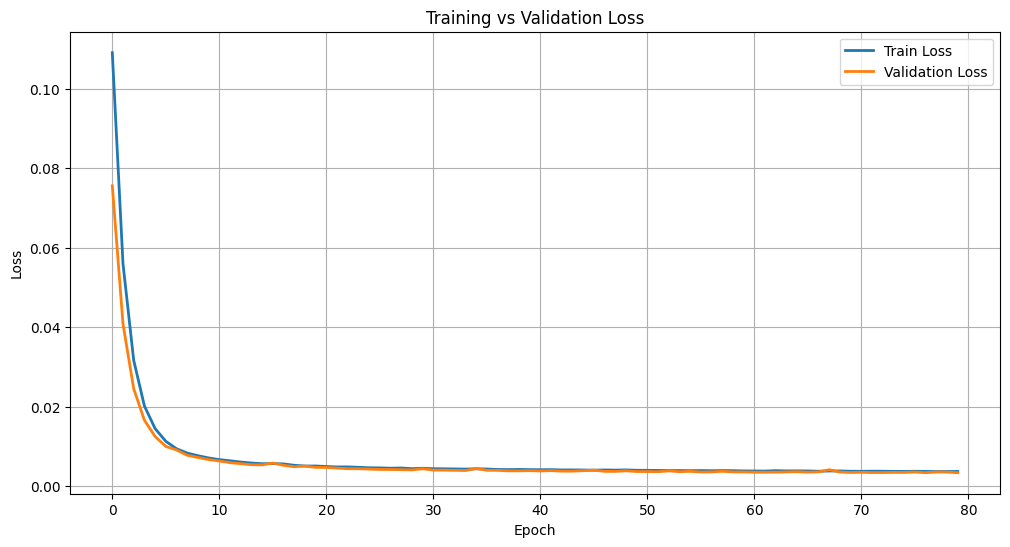

Saved loss curve to: C:\Users\srust\OneDrive\Desktop\OUTPUT LSTM\loss_curve.png


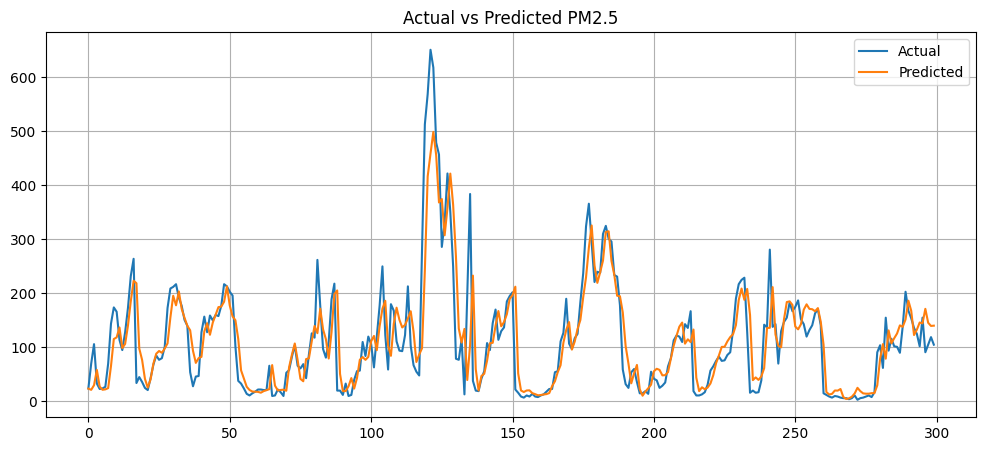

Saved prediction plot to: C:\Users\srust\OneDrive\Desktop\OUTPUT LSTM\actual_vs_predicted.png


In [6]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import tensorflow as tf

from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras import regularizers

df = pd.read_csv(r'C:\Users\srust\Downloads\data.csv')
df = df.rename(columns={"pm2.5": "pm25"})
df = df.ffill().bfill()


df = df.iloc[::3].reset_index(drop=True)
print("Dataset size after downsampling:", len(df))


ohe = OneHotEncoder(sparse_output=False, handle_unknown="ignore")
cbwd_encoded = ohe.fit_transform(df[['cbwd']])
cbwd_cols = [f"cbwd_{c}" for c in ohe.categories_[0]]
df_ohe = pd.DataFrame(cbwd_encoded, columns=cbwd_cols, index=df.index)


features = ["pm25", "DEWP", "TEMP", "PRES", "Iws", "Is", "Ir"]
data_all = pd.concat([df[features], df_ohe], axis=1)


scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data_all.values)


look_back = 12

def create_sequences(data, look_back):
    X, Y = [], []
    for i in range(len(data) - look_back):
        X.append(data[i:i+look_back])
        Y.append(data[i+look_back, 0])
    return np.array(X), np.array(Y)

X, y = create_sequences(scaled_data, look_back)


split = int(len(X) * 0.8)
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

print("Train shape:", X_train.shape)
print("Test shape:", X_test.shape)


model = Sequential([

    LSTM(64, return_sequences=True, 
         kernel_regularizer=regularizers.l2(0.001)),

    LSTM(32, kernel_regularizer=regularizers.l2(0.001)),

    Dense(32, activation='relu',
          kernel_regularizer=regularizers.l2(0.001)),

    Dense(1)
])

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0003),
    loss='mse'
)

model.summary()

-
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=80,
    batch_size=64,   # <-- IMPORTANT FOR TOUCHING CURVES
    verbose=1
)


def invert_pm25(vals):
    dummy = np.zeros((len(vals), scaled_data.shape[1]))
    dummy[:,0] = vals.flatten()
    return scaler.inverse_transform(dummy)[:,0]

y_pred = model.predict(X_test)
y_pred_inv = invert_pm25(y_pred)
y_test_inv = invert_pm25(y_test)

output_dir = r"C:\Users\srust\OneDrive\Desktop\OUTPUT LSTM"
os.makedirs(output_dir, exist_ok=True)


plt.figure(figsize=(12,6))
plt.plot(history.history['loss'], label='Train Loss', linewidth=2)
plt.plot(history.history['val_loss'], label='Validation Loss', linewidth=2)
plt.title("Training vs Validation Loss ")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)

plt.savefig(rf"{output_dir}\loss_curve.png", dpi=300, bbox_inches="tight")
plt.show()

print("Saved loss curve to:", rf"{output_dir}\loss_curve.png")


plt.figure(figsize=(12,5))
plt.plot(y_test_inv[:300], label='Actual')
plt.plot(y_pred_inv[:300], label='Predicted')
plt.title("Actual vs Predicted PM2.5")
plt.grid(True)
plt.legend()

plt.savefig(rf"{output_dir}\actual_vs_predicted.png", dpi=300, bbox_inches="tight")
plt.show()

print("Saved prediction plot to:", rf"{output_dir}\actual_vs_predicted.png")


In [9]:
import pandas as pd
import os

output_dir = r"C:\Users\srust\OneDrive\Desktop"
os.makedirs(output_dir, exist_ok=True)


results_df = pd.DataFrame({
    "Actual_PM25": y_test_inv,
    "Predicted_PM25": y_pred_inv
})


csv_path = rf"{output_dir}\pm25_predictions.csv"
results_df.to_csv(csv_path, index=False)

print("Saved prediction CSV to:", csv_path)


Saved prediction CSV to: C:\Users\srust\OneDrive\Desktop\pm25_predictions.csv
